In [1]:
%%capture
! pip install tensorflow-model-optimization
! pip install ipywidgets

In [2]:
import gzip, os, pickle

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot
import ipywidgets as ipyw
import numpy as np

from pathlib import Path
from tensorflow.keras import layers, optimizers, metrics, losses, models
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model, array_to_img
from matplotlib import pyplot as plt

In [3]:
!pip install -q git+https://github.com/EfficientDL/codelab_utils.git

import matplotlib.pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

In [4]:
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'oxford_iiit_pet',
    with_info=True,
    split=['train[:80%]', 'train[80%:]', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

In [5]:
# Dataset image size
IMG_SIZE = 128

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    
    return image, mask

def preprocess(item):
    image, mask = item['image'], item['segmentation_mask']
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
    image, mask = normalize(image, mask)
    
    return image, mask

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_prep_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

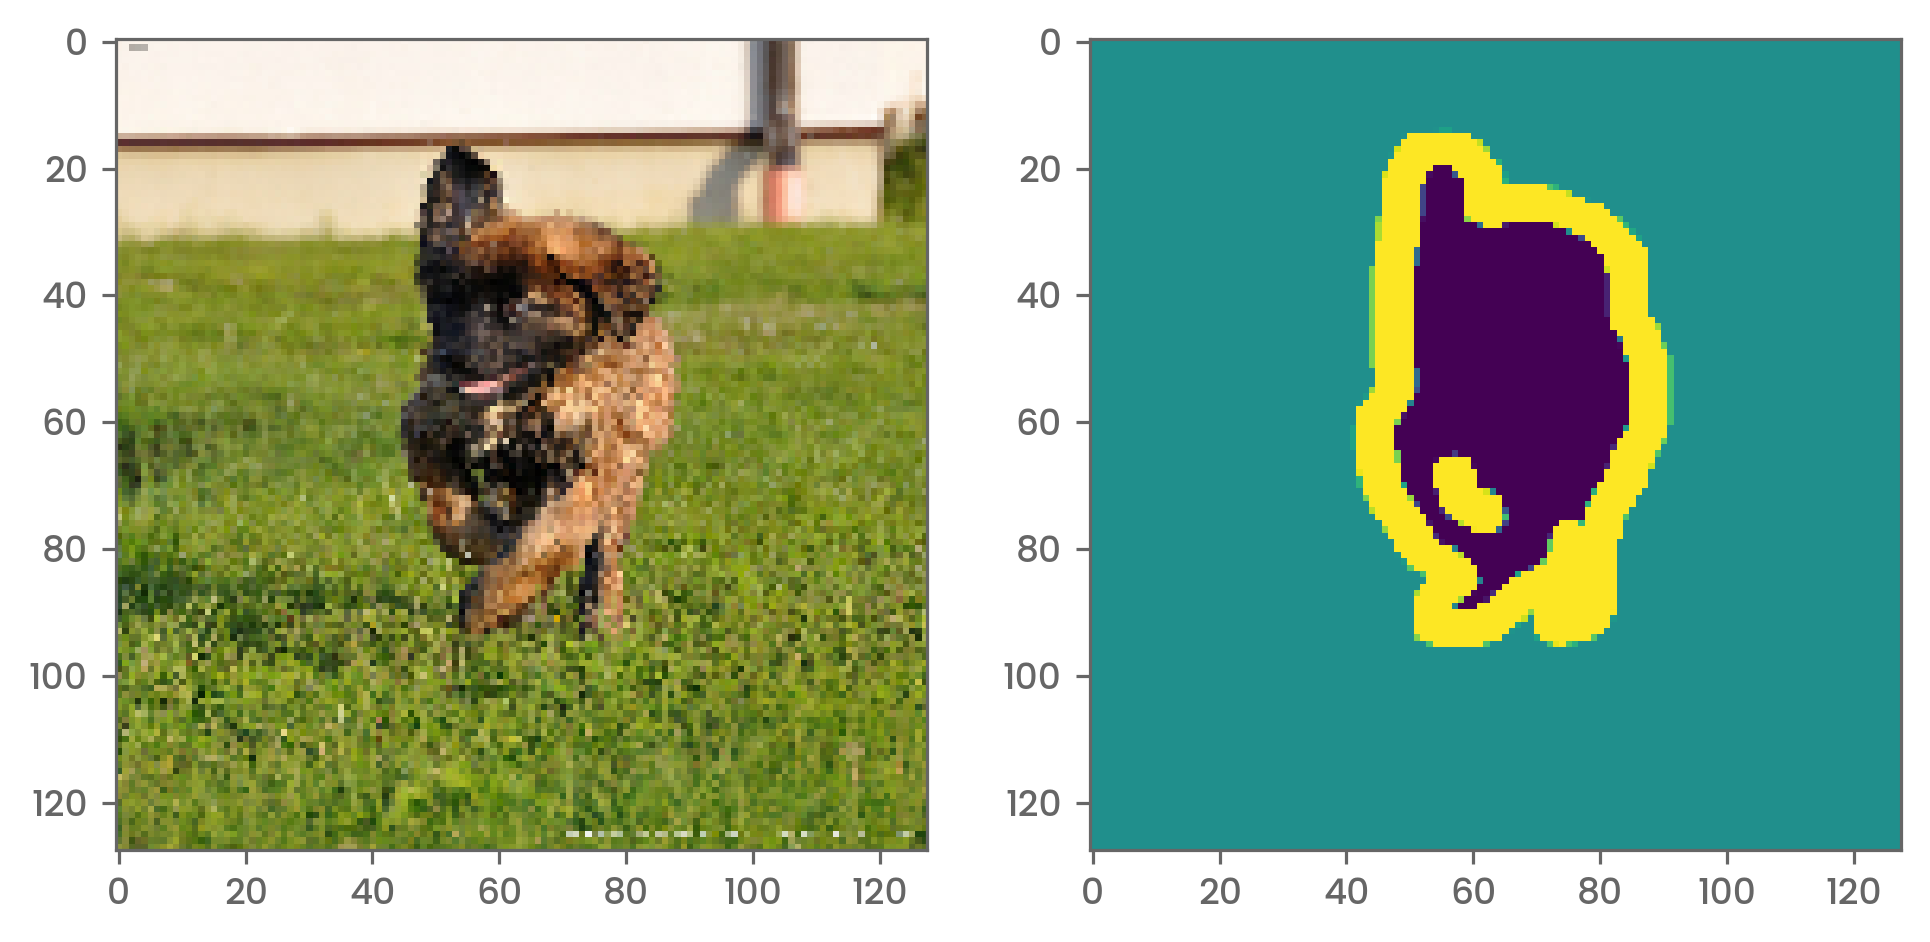

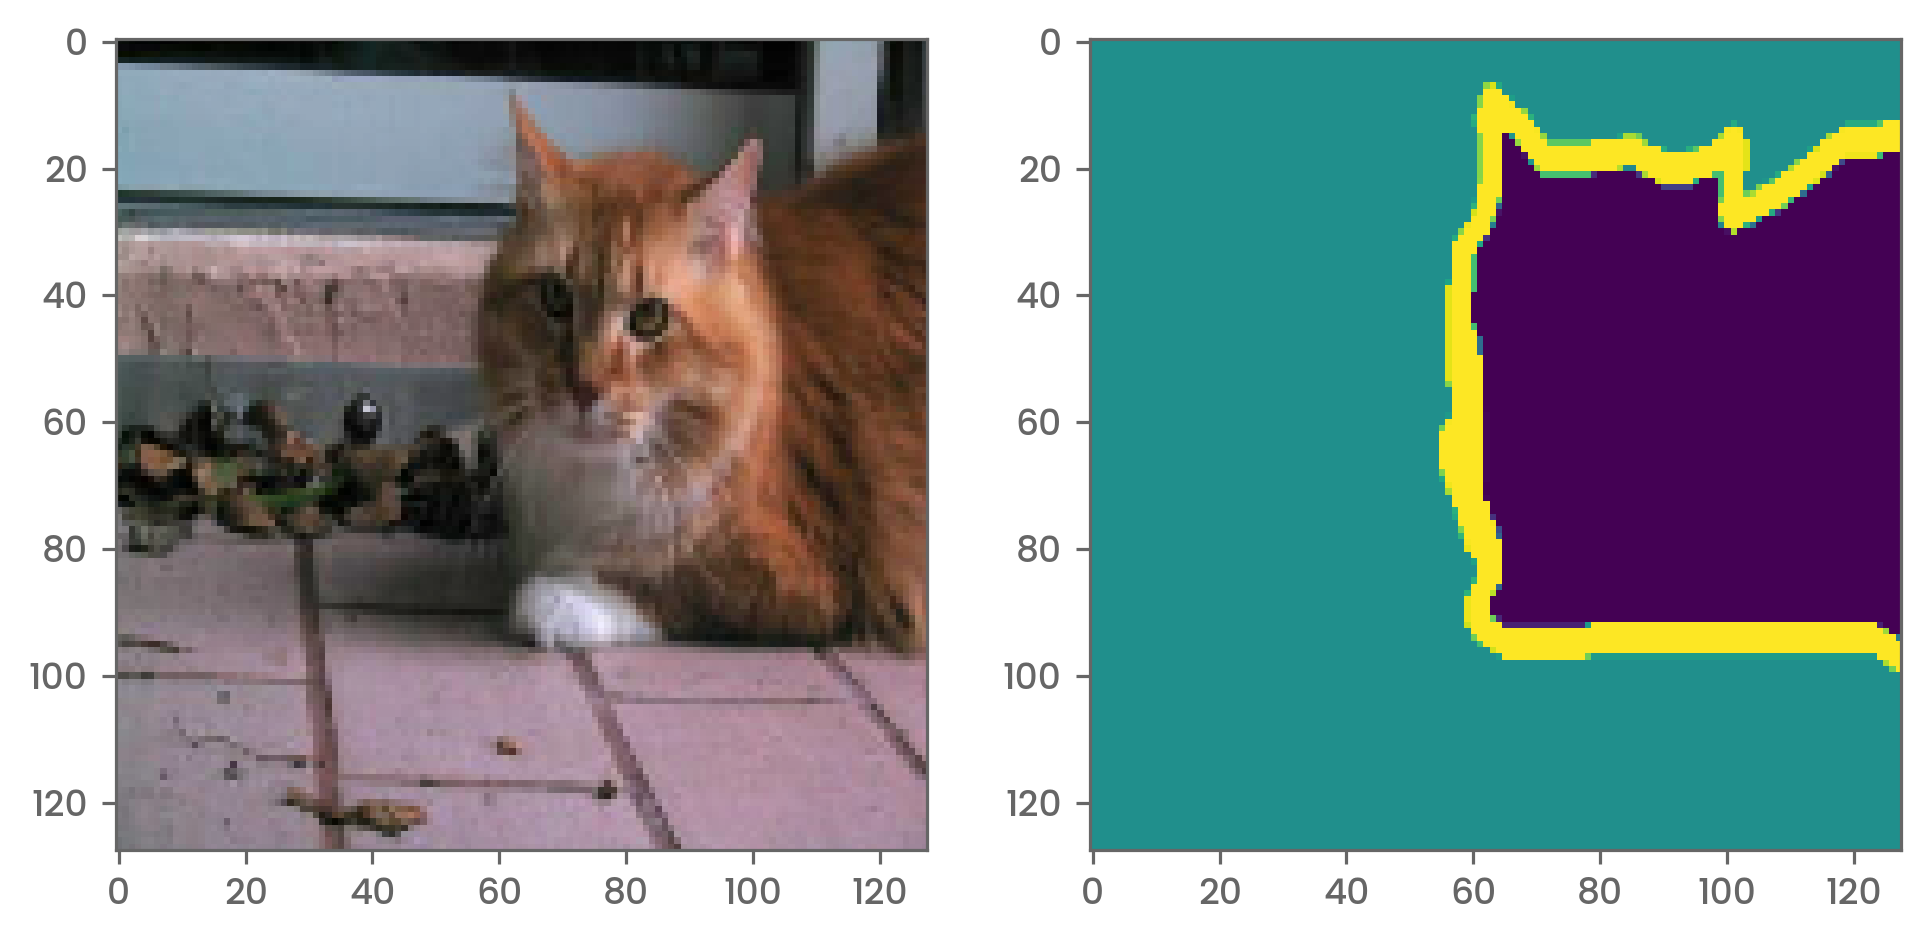

In [6]:
def display_samples(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, image in enumerate(display_list):
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(display_list[index]))

for image, mask in test_prep_ds.take(2):
    display_samples([image, mask])

In [7]:
LEARNING_RATE = 0.001
N_CLASSES = 3

layer_id = -1

def get_layer_id():
    global layer_id
    layer_id += 1
    
    return str(layer_id)
    
def get_conv_block(filters, strides, padding='same'):
    return tf.keras.Sequential(
        [
            layers.Conv2D(filters, 3, padding=padding, strides=strides),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='conv_block_' + get_layer_id()
    )

def get_dsc_block(filters, strides, padding='same'):
    return tf.keras.Sequential(
        [
            layers.DepthwiseConv2D(3, padding=padding, strides=strides),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, 1, padding='valid', strides=1),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='dsc_block_' + get_layer_id()
    )

def get_conv_transpose_block(filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    kwargs = dict(strides=2, padding='same', kernel_initializer=initializer, use_bias=False)
    
    return tf.keras.Sequential(
        [
            layers.Conv2DTranspose(filters, 3, **kwargs),
            layers.BatchNormalization(),
            layers.ReLU()
        ],
        name='conv_transpose_block_' + get_layer_id()
    )

def get_conv_builder(block_type='conv'):
    if (block_type == 'conv'):
        return get_conv_block
    elif (block_type == 'dsc'):
        return get_dsc_block
    else:
        raise ValueError('Invalid block type: ', block_type)

def create_model(conv_type='conv'):
    builder = get_conv_builder(conv_type)
    model = tf.keras.Sequential([
            tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            get_conv_block(32, strides=2),
            builder(64, strides=1),
            builder(128, strides=2),
            builder(128, strides=1),
            builder(256, strides=2),
            builder(256, strides=1),
            builder(512, strides=2),
            builder(512, strides=1),
            builder(512, strides=1),
            builder(512, strides=1),
            builder(512, strides=1),
            builder(512, strides=1),
            builder(1024, strides=2),
            get_conv_transpose_block(512),
            get_conv_transpose_block(256),
            get_conv_transpose_block(128),
            get_conv_transpose_block(64),
            get_conv_transpose_block(3),
    ])

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_0 (Sequential)   (None, 64, 64, 32)        1024      
                                                                 
 conv_block_1 (Sequential)   (None, 64, 64, 64)        18752     
                                                                 
 conv_block_2 (Sequential)   (None, 32, 32, 128)       74368     
                                                                 
 conv_block_3 (Sequential)   (None, 32, 32, 128)       148096    
                                                                 
 conv_block_4 (Sequential)   (None, 16, 16, 256)       296192    
                                                                 
 conv_block_5 (Sequential)   (None, 16, 16, 256)       591104    
                                                                 
 conv_block_6 (Sequential)   (None, 8, 8, 512)         1

In [8]:
from google.colab import files

# files.download('model.results.pkl')
# files.download('weights.h5')
# files.download('pruning_2_13.results.pkl')
# files.download('stripped_2_13_model.h5')

In [9]:
if not Path('weights.h5').exists():
    ! wget "https://www.dropbox.com/s/mo5xrafnei98uuf/oxford_pets_conv_weights.h5?dl=1" -O weights.h5
model.load_weights('weights.h5')

In [10]:
def create_model_for_pruning(m, prunables, info=True):
    def apply_pruning_to_conv_blocks(block):
        clone_block = models.clone_model(block)
        clone_block.set_weights(block.get_weights())
        
        if block.name in prunables:
            clone_block = tfmot.sparsity.keras.prune_low_magnitude(clone_block)

        return clone_block
    
    model_for_pruning = models.clone_model(
        m,
        clone_function=apply_pruning_to_conv_blocks,
    )

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model_for_pruning.compile(
        optimizer=optimizer,
        loss=loss,
        metrics='accuracy'
    )

    return model_for_pruning

In [11]:
# Pruning start and end blocks
prunable_blocks = list(map(lambda l: l.name, model.layers[2:13]))
model_for_pruning = create_model_for_pruning(model, prunable_blocks)
prunable_layers = filter(lambda l: l.name in prunable_blocks, model_for_pruning.layers)

print('Enabled blocks:', prunable_blocks, 'for pruning')
for layer in prunable_layers:
    layer.summary()

Enabled blocks: ['conv_block_2', 'conv_block_3', 'conv_block_4', 'conv_block_5', 'conv_block_6', 'conv_block_7', 'conv_block_8', 'conv_block_9', 'conv_block_10', 'conv_block_11', 'conv_block_12'] for pruning
Model: "conv_block_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 32, 32, 128)      147586    
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_batch_n  (None, 32, 32, 128)      513       
 ormalization_2 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_re_lu_2  (None, 32, 32, 128)      1         
  (PruneLowMagnitude)                                            
                                            

In [12]:
def train(m, tds, vds, epochs=100, callbacks=[]):
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE) if vds else None
    history = m.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)

    return history

def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', edgecolor='k')

    axes[0].plot(h['loss'], label='Loss')
    axes[0].plot(h['val_loss'], label='Validation Loss')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Losses')

    axes[1].plot(h['accuracy'], label='Accuracy')
    axes[1].plot(h['val_accuracy'], label='Validation Accuracy')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracies')

    fig.legend()

Epoch 1/35
184/184 [==============================] - 38s 86ms/step - loss: 0.0874 - accuracy: 0.9574 - val_loss: 0.5412 - val_accuracy: 0.8498
Epoch 2/35
184/184 [==============================] - 11s 61ms/step - loss: 0.0835 - accuracy: 0.9589 - val_loss: 0.5519 - val_accuracy: 0.8503
Epoch 3/35
184/184 [==============================] - 11s 61ms/step - loss: 0.0770 - accuracy: 0.9613 - val_loss: 0.5745 - val_accuracy: 0.8483
Epoch 4/35
184/184 [==============================] - 11s 61ms/step - loss: 0.0747 - accuracy: 0.9622 - val_loss: 0.5696 - val_accuracy: 0.8512
Epoch 5/35
184/184 [==============================] - 10s 57ms/step - loss: 0.0724 - accuracy: 0.9629 - val_loss: 0.5761 - val_accuracy: 0.8508
Epoch 6/35
184/184 [==============================] - 10s 56ms/step - loss: 0.0706 - accuracy: 0.9636 - val_loss: 0.5967 - val_accuracy: 0.8505
Epoch 7/35
184/184 [==============================] - 10s 55ms/step - loss: 0.0692 - accuracy: 0.9641 - val_loss: 0.6029 - val_accuracy:

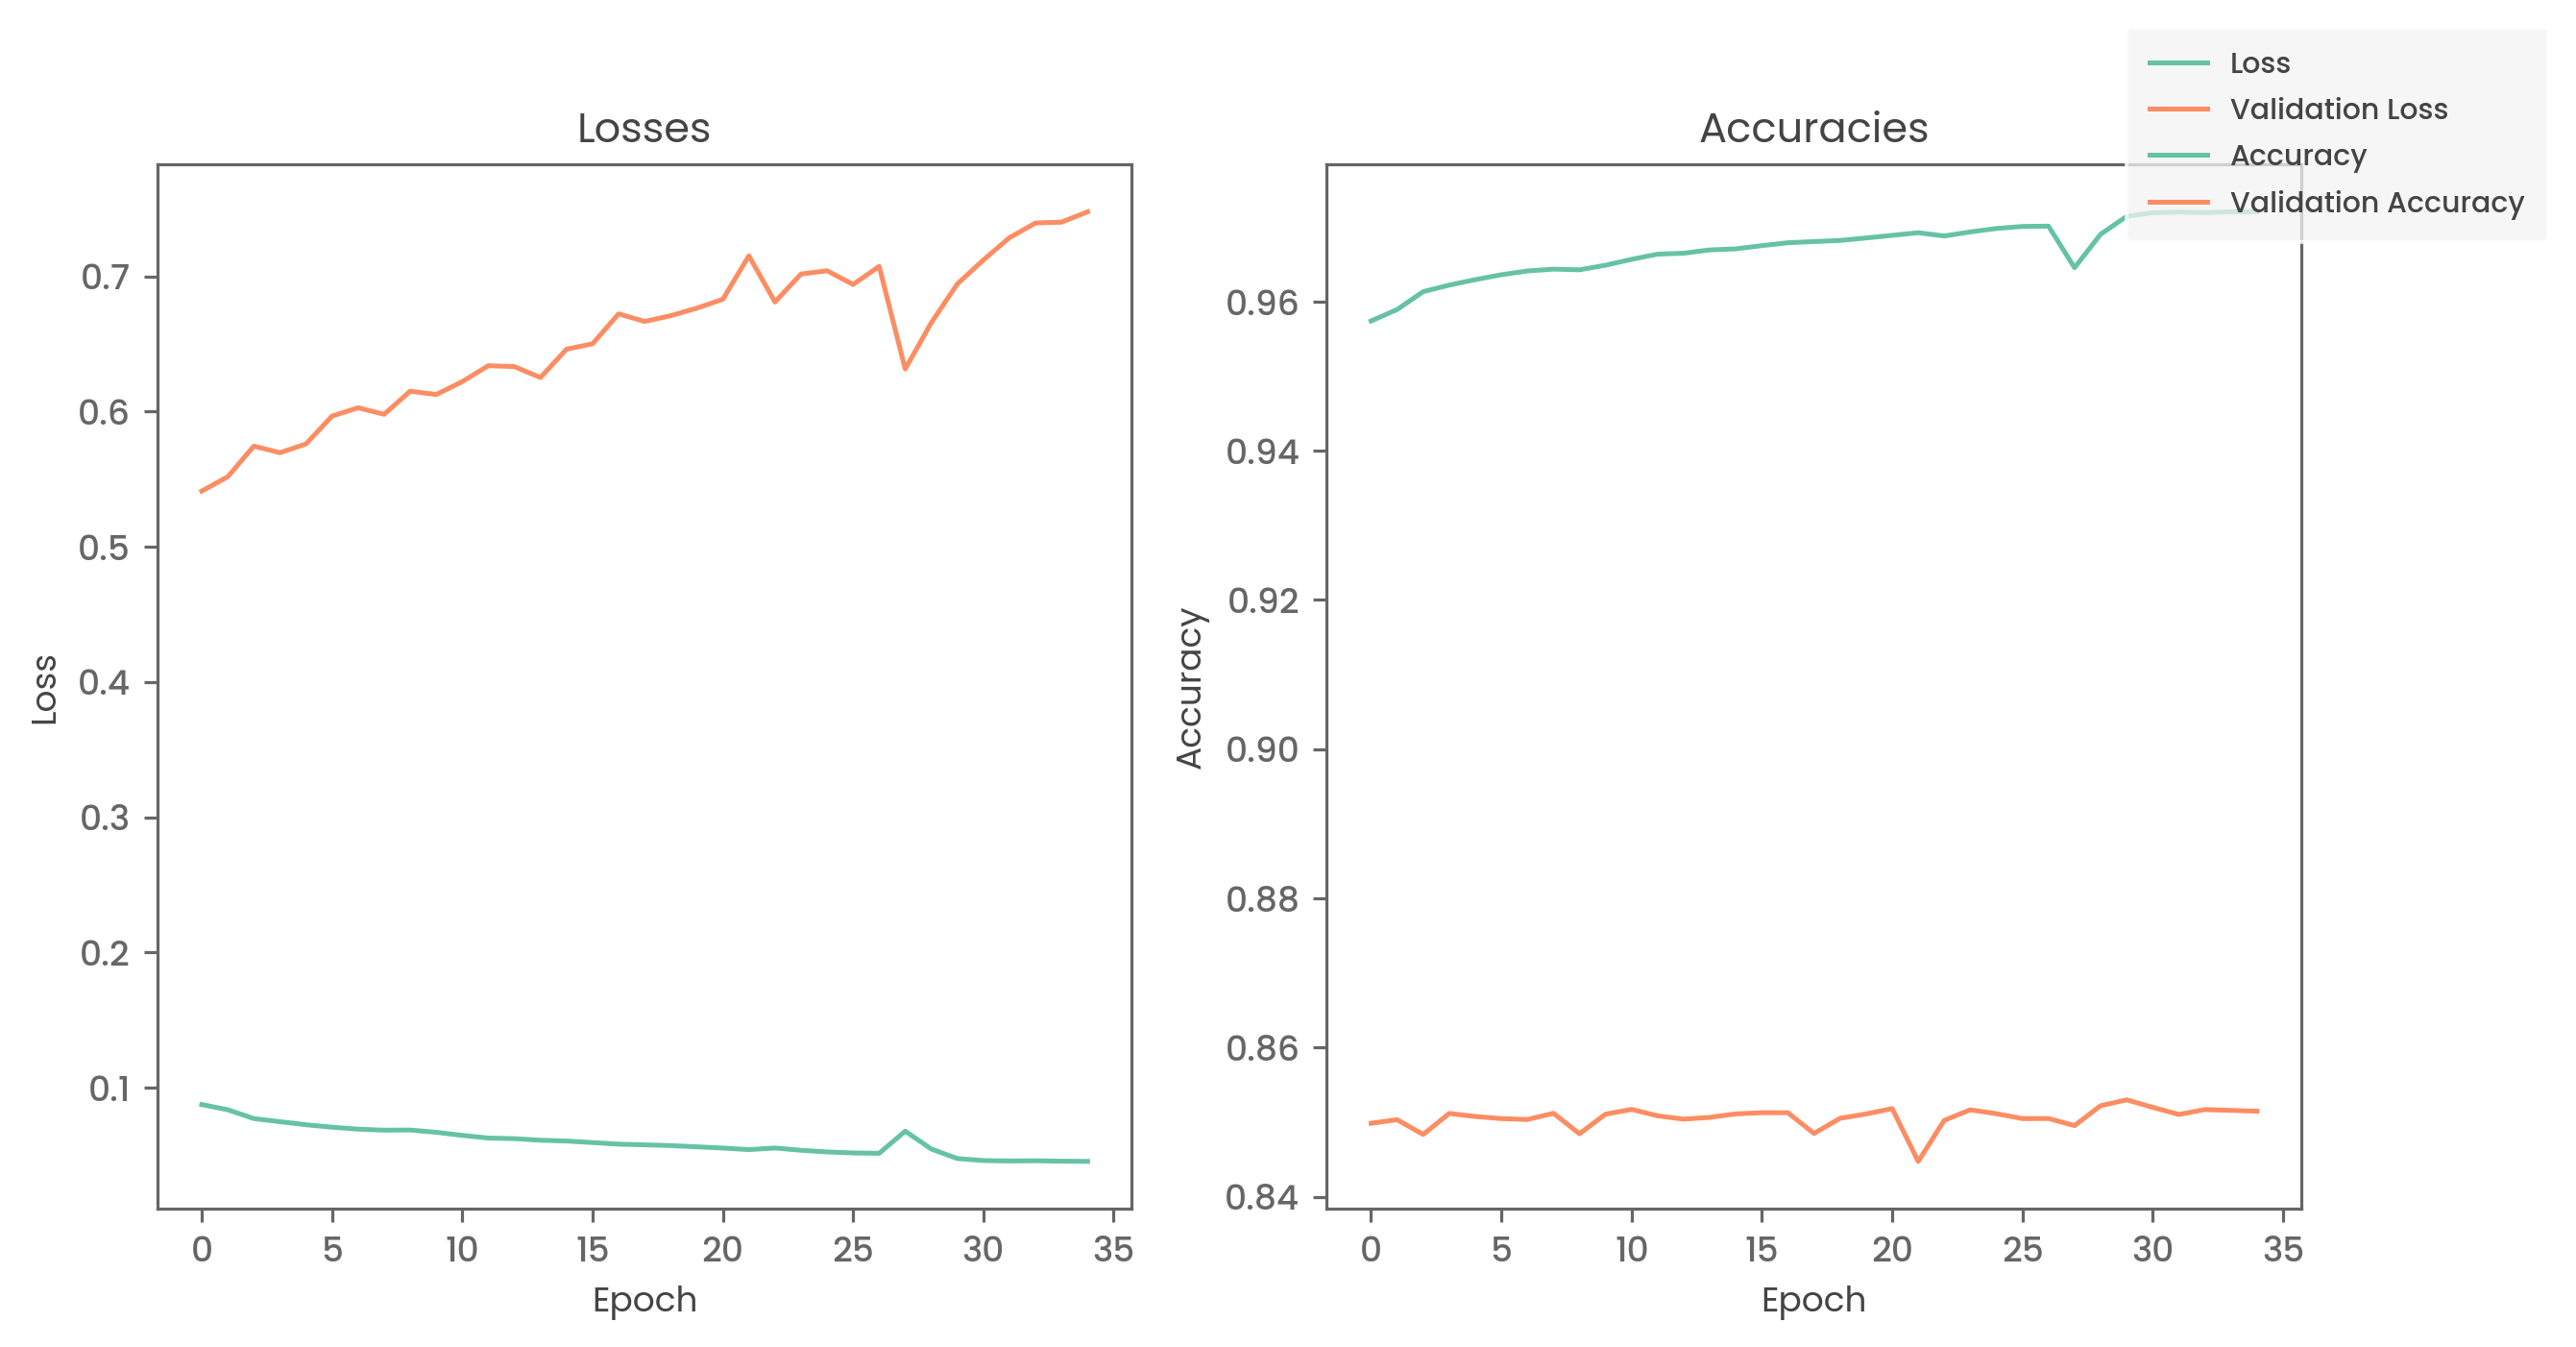

In [13]:
checkpoint_name_tmpl = 'pruned_model/weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
checkpoint = cbs.ModelCheckpoint(checkpoint_name_tmpl, save_best_only=True, monitor="val_accuracy")
update_pruning = tfmot.sparsity.keras.UpdatePruningStep()

# EPOCHS = 1
EPOCHS = 35
BATCH_SIZE = 16

callbacks = [checkpoint, update_pruning]
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = val_prep_ds.batch(256).cache()

hist = train(model_for_pruning, tds, vds, epochs=EPOCHS, callbacks=callbacks)

with open('pruning.results.pkl', 'wb') as f:
    pickle.dump(hist.history, f)

plot_history(hist.history)
model_for_pruning_acc = model_for_pruning.evaluate(test_prep_ds.batch(256))[1]
stripped_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

In [14]:
from google.colab import files

# files.download('model.results.pkl')
# files.download('weights.h5')
# files.download('pruning_2_13.results.pkl')
# files.download('stripped_2_13_model.h5')

In [15]:
def get_conv_block_sparsity(block):
    # Get block conv layer weights
    conv_weights = block.weights[0].numpy()
    non_zeros = np.count_nonzero(conv_weights)
    total = conv_weights.size
    zeros = total - non_zeros
    sparsity = (zeros/total)*100

    return (sparsity, total)

for block in stripped_model.layers:
    sparsity, total = get_conv_block_sparsity(block)
    print('Block: {} Sparsity: {}% Total Weights: {}'.format(block.name, sparsity, total))

Block: conv_block_0 Sparsity: 0.0% Total Weights: 864
Block: conv_block_1 Sparsity: 0.0% Total Weights: 18432
Block: conv_block_2 Sparsity: 50.0% Total Weights: 73728
Block: conv_block_3 Sparsity: 50.0% Total Weights: 147456
Block: conv_block_4 Sparsity: 50.0% Total Weights: 294912
Block: conv_block_5 Sparsity: 50.0% Total Weights: 589824
Block: conv_block_6 Sparsity: 50.0% Total Weights: 1179648
Block: conv_block_7 Sparsity: 50.0% Total Weights: 2359296
Block: conv_block_8 Sparsity: 50.0% Total Weights: 2359296
Block: conv_block_9 Sparsity: 50.0% Total Weights: 2359296
Block: conv_block_10 Sparsity: 50.0% Total Weights: 2359296
Block: conv_block_11 Sparsity: 50.0% Total Weights: 2359296
Block: conv_block_12 Sparsity: 50.0% Total Weights: 4718592
Block: conv_transpose_block_13 Sparsity: 0.0% Total Weights: 4718592
Block: conv_transpose_block_14 Sparsity: 0.0% Total Weights: 1179648
Block: conv_transpose_block_15 Sparsity: 0.0% Total Weights: 294912
Block: conv_transpose_block_16 Sparsi

In [16]:
# Save TFLite model to a file
def convert_to_tflite(m, file):
    converter = tf.lite.TFLiteConverter.from_keras_model(m)
    tflite_model = converter.convert()
    with open(file, 'wb') as f:
        f.write(tflite_model)

# Create a compressed copy of input file and return its size
def get_compressed_size_in_kbs(file):
    path = Path(file)
    compressed_file = path.parent / (path.name + '.gz')

    with gzip.open(compressed_file, 'wb') as out:
        with open(file, 'rb') as inp:
            out.write(inp.read())
        
    return compressed_file.stat().st_size/1024.

In [17]:
model_file = 'model.h5'
stripped_model_file = 'stripped_model.h5'
model_tflite_file = str(Path(model_file).with_suffix('.tflite'))
stripped_model_tflite_file = str(Path(stripped_model_file).with_suffix('.tflite'))

# Save Models
models.save_model(model, model_file, include_optimizer=False)
models.save_model(stripped_model, stripped_model_file, include_optimizer=False)

convert_to_tflite(model, model_tflite_file)
convert_to_tflite(stripped_model, stripped_model_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpimvsqg7w/assets


INFO:tensorflow:Assets written to: /tmp/tmpimvsqg7w/assets


INFO:tensorflow:Assets written to: /tmp/tmpkowu4boe/assets


INFO:tensorflow:Assets written to: /tmp/tmpkowu4boe/assets


In [18]:
model_size = get_compressed_size_in_kbs(model_file)
stripped_model_size = get_compressed_size_in_kbs(stripped_model_file)

model_tflite_size = get_compressed_size_in_kbs(model_tflite_file)
stripped_model_tflite_size = get_compressed_size_in_kbs(stripped_model_tflite_file)

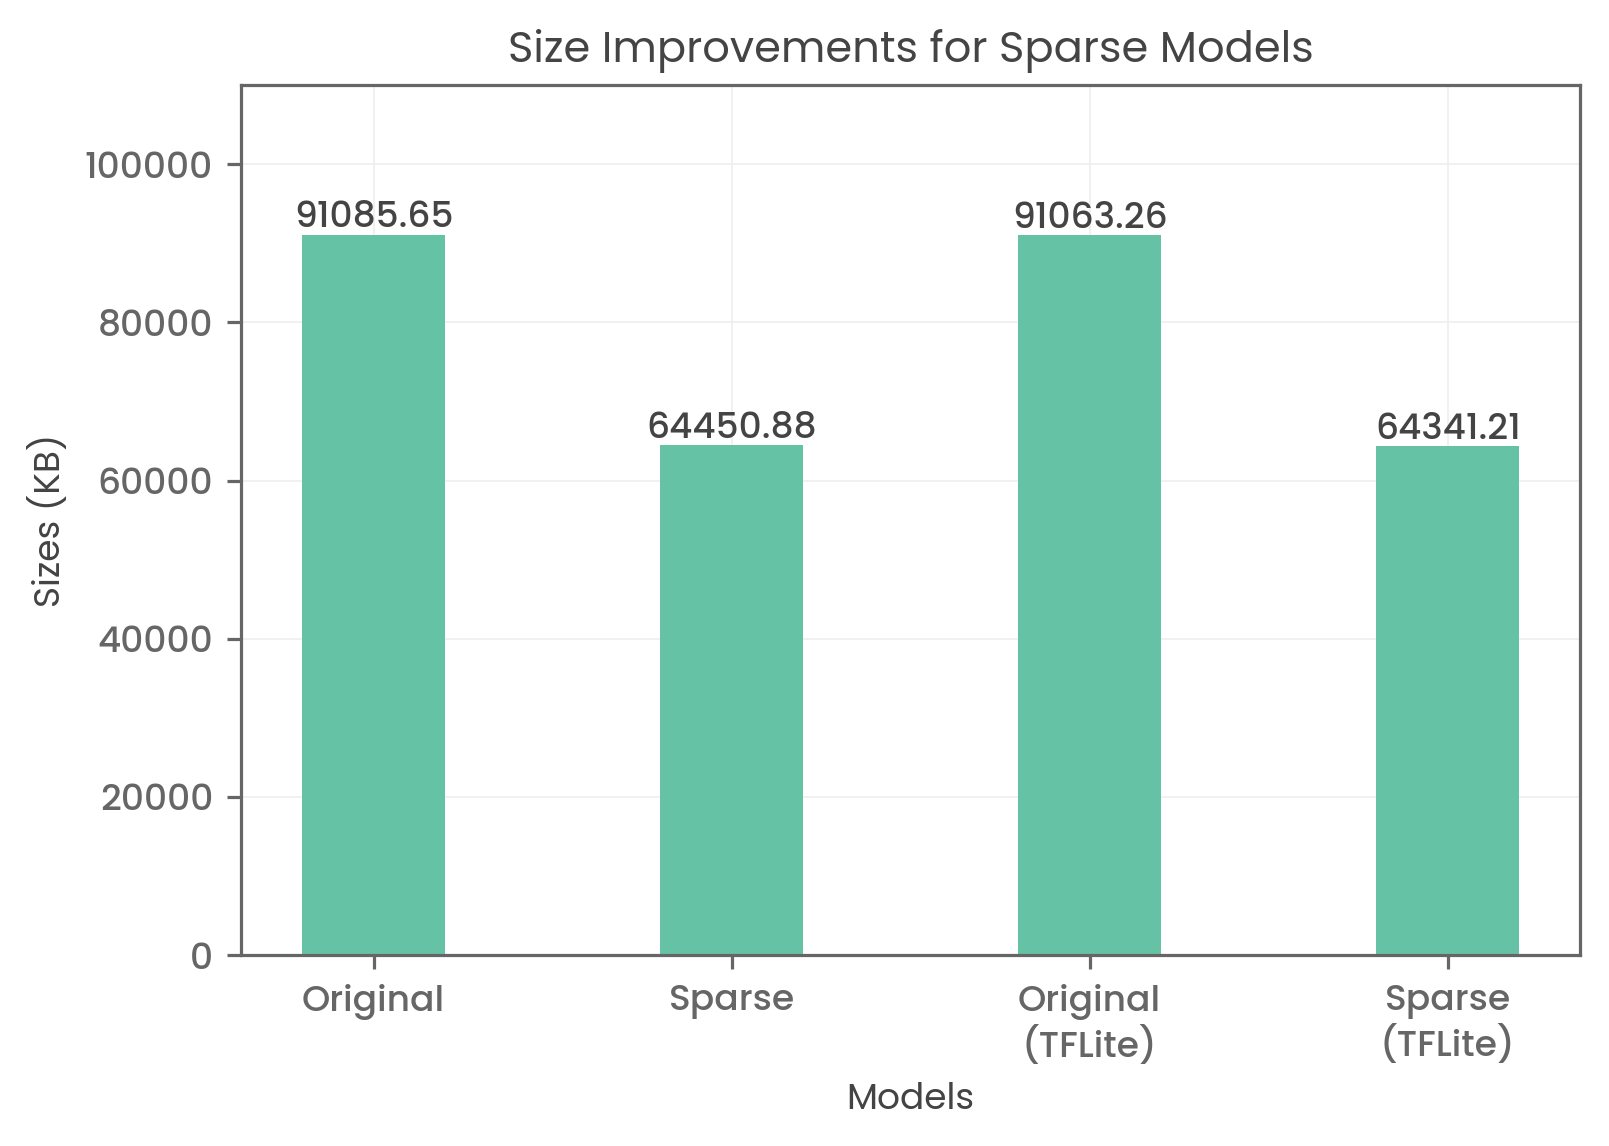

Labels: ['Original', 'Sparse', 'Original\n(TFLite)', 'Sparse\n(TFLite)']
Sizes: [91085.650390625, 64450.8779296875, 91063.2607421875, 64341.2119140625]


In [33]:
labels = ['Original', 'Sparse', 'Original\n(TFLite)', 'Sparse\n(TFLite)']
sizes = [
         model_size, 
         stripped_model_size,
         model_tflite_size,
         stripped_model_tflite_size
    ]

plt.ylim(0, 110000)
plt.bar(labels, sizes, width=0.4)

for idx, size in enumerate(sizes):
  plt.text(idx, sizes[idx] + 1000, 
           f'{sizes[idx]:.2f}', ha='center')
 
plt.xlabel('Models')
plt.ylabel('Sizes (KB)')
plt.title('Size Improvements for Sparse Models')
plt.grid()
plt.show()

print('Labels:', labels)
print('Sizes:', sizes)

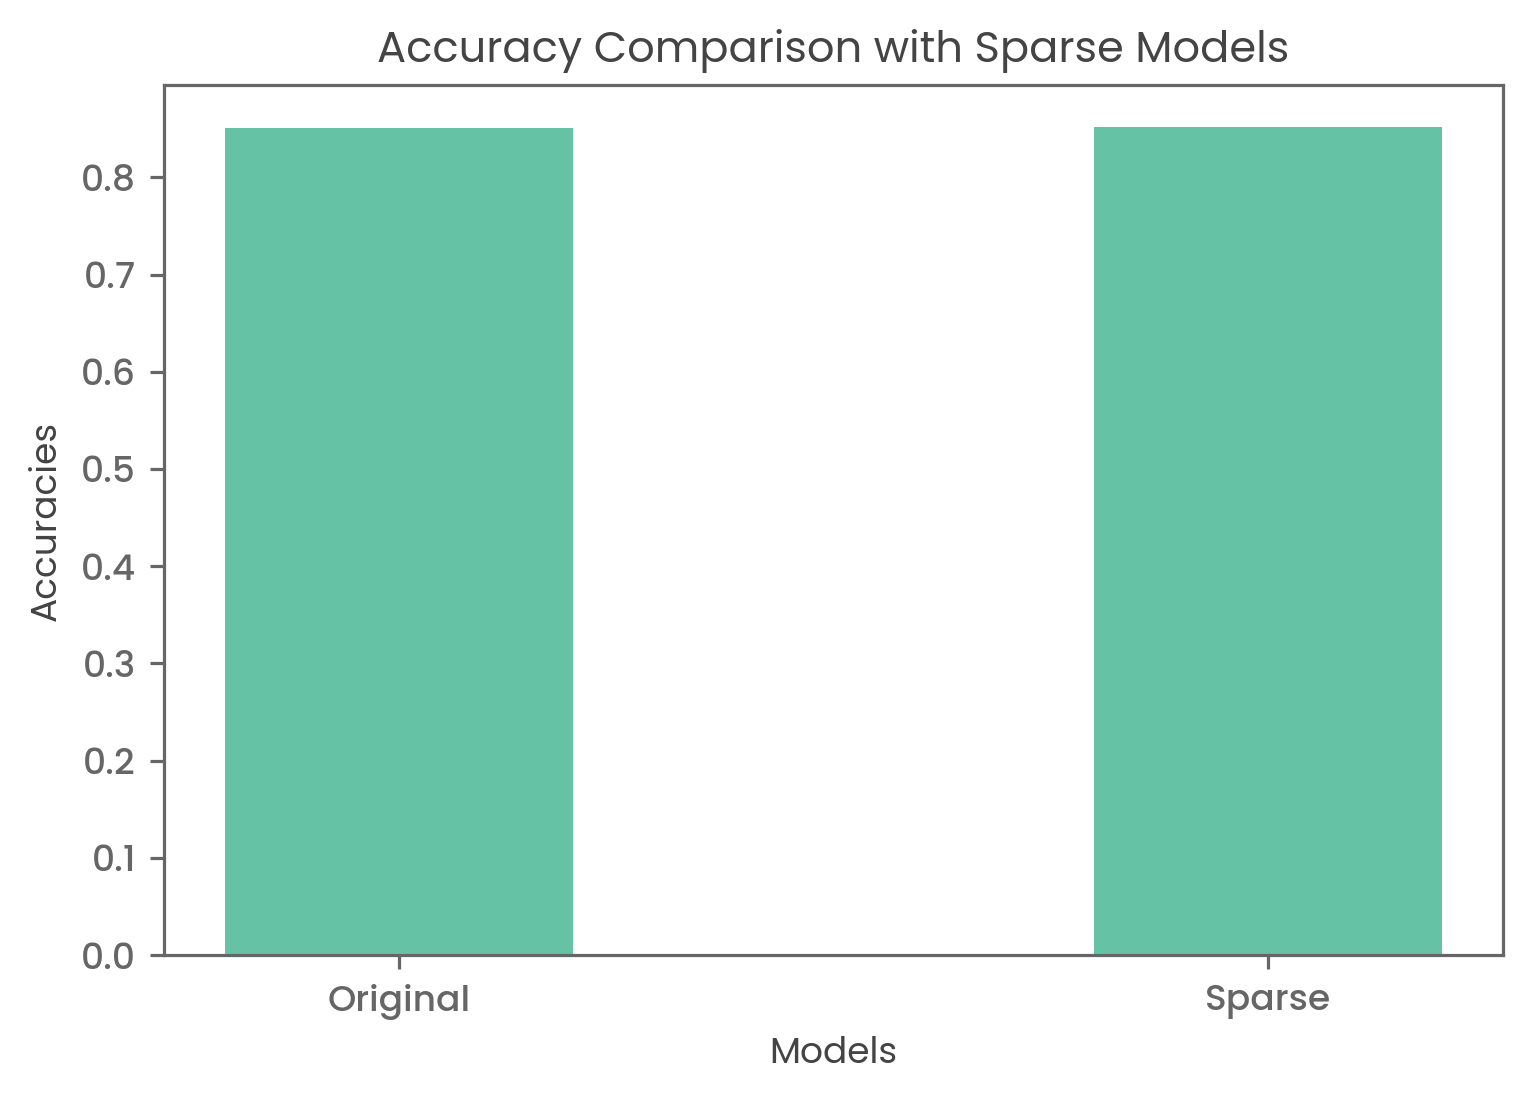

Labels: ['Original', 'Sparse']
Accuracies: [0.8511, 0.8519057631492615]


In [20]:
labels = ['Original', 'Sparse']
accuracies = [0.8511, model_for_pruning_acc]
 
plt.bar(labels, accuracies, width=0.4)
 
plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.title('Accuracy Comparison with Sparse Models')
plt.show()

print('Labels:', labels)
print('Accuracies:', accuracies)

In [21]:
from google.colab import files

# files.download('pruning.results.pkl') 
# files.download('model.h5')
# files.download('pruning_2_13.results.pkl')
# files.download('stripped_2_13_model.h5')